# Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [2]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')
dataset = data.copy()

## General overview

In [3]:
dataset.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


We have 11 columns (excluding the index column, *PassengerId*). 6 of them are numerical as we can see in the following summary: 

In [4]:
dataset.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The 5 others are of class type.

In [5]:
dataset.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

We will process those fields to have only categorical data at the end. This will allow us to group similar slices of numerical features into more relevant features, and reduce the total number of degrees of freedom to ensure better reproductibility (often called generalization).

## Exploring and Pre-processing the data

### Cabin (plus Ticket and Pclass)

We need to format some inputs such as the *Cabin* which have a lot of 'NaN', and may have a not straightforward enough input as shown here:

In [6]:
dataset[27:28]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S


When a family booked *Cabins*, all the booked *Cabins* are recorded for each family member:

In [7]:
dataset[dataset['Cabin']=='C23 C25 C27']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S
439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S


We will start assuming only the cabin 'section' (*C* in this case) does matter, assuming all the same letter cabins are located nearby. We also need to split the fare across the number of booked cabins to make the feature 'Fare' really relevant as illustrated above. When the cabin field is empty (NaN), we use the multiplicity of *Tickets* to do this normalization. It is not exactly the same as you can see above, but it's better than nothing.

Let's split the fare across the number of cabin for a given passenger (or the multiplicity of the ticket), replace the 'NaN' by a dummy cabin class 'Z', and keep only the cabin class instead of the total cabin reference:

In [8]:
# Ticket: use the number of identical ticket delivered to normalize fare if Cabin is NaN
dataset['Cabin'].fillna('Z', inplace=True)
ticket = dataset['Ticket'].value_counts().to_dict()
ticketreduced = dict((k, v) for k, v in ticket.items() if v >= 2) # what needs to be normalized
for item in ticketreduced.keys():
    dataset.loc[(dataset['Ticket']==item) & (dataset['Cabin']=='Z'),'Fare'] \
          = dataset.loc[(dataset['Ticket']==item) & (dataset['Cabin']=='Z'),'Fare'] / ticketreduced[item]

# Fare: normalize by number of cabin booked
dataset['Cabin'] = dataset['Cabin'].str.split()
normfactor = dataset['Cabin'].apply(lambda x: len(x))
dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True) # only 1 data entry concerned
dataset['Fare'] = dataset['Fare']/normfactor

# Cabin: convert to cat.-feat. and reduce it to 2 classes
dataset['Cabin'] = dataset['Cabin'].astype(str).str[2]

I didn't see any other use for the *Ticket* feature, so I will discard it for the final model in order to reduce dimensionality of our problem. 

Let's check what are our different possibilities for the *Cabin* feature now:

In [9]:
dataset['Cabin'].unique()

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

We now convert the 'Cabin' label into a numerical feature to plot it. We use a function from *sklearn* for this. Note that the cabin are ordered automatically using this transformation:

In [10]:
le = preprocessing.LabelEncoder()
le.fit_transform(dataset['Cabin'])
le.transform(dataset['Cabin'])
list(le.inverse_transform([0,1,2,3,4,5,6,7,8]))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z']

In [11]:
dataset['Cabin'] = le.fit_transform(dataset['Cabin'])

Let's plot the **'Cabin' - 'Survived'** dependency now:

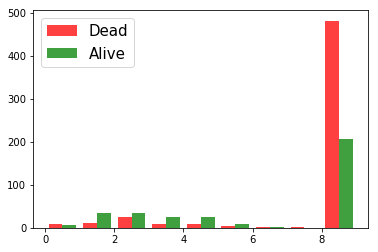

In [12]:
dead = dataset.loc[dataset['Survived']==0,'Cabin']
alive = dataset.loc[dataset['Survived']==1,'Cabin']
binBoundaries = np.linspace(0,9,10)
fig = plt.hist([dead,alive], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
plt.legend(['Dead','Alive'],loc=0,prop={'size': 15})

Given the distribution of the data, we better have to reduce it to fewer categories as one is dominating the others (the last cabin type, 'Nan'). Additionnally, this feature is aprtially correlated with the *Pclass* feature. What we can do to reduce the number of features and make it more relevant, is to create a new one based on *Cabin* bucketization depending on the *Pclass*. We will call it *Location*.

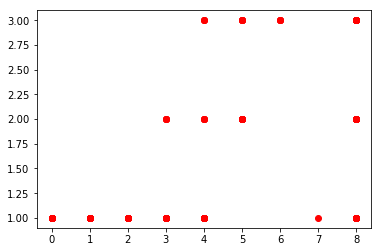

In [13]:
fig = plt.plot(dataset['Cabin'], dataset['Pclass'],'ro');

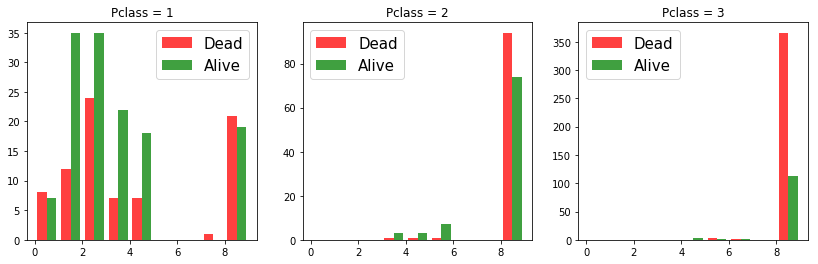

In [14]:
f, axarr = plt.subplots(1, 3,figsize=(14, 4))
binBoundaries = np.linspace(0,9,10)

x1 = dataset.loc[(dataset['Survived']==0) & (dataset['Pclass']==1),'Cabin']
y1 = dataset.loc[(dataset['Survived']==1) & (dataset['Pclass']==1),'Cabin']
axarr[0].hist([x1,y1], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0].set_title('Pclass = 1')
axarr[0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x2 = dataset.loc[(dataset['Survived']==0) & (dataset['Pclass']==2),'Cabin']
y2 = dataset.loc[(dataset['Survived']==1) & (dataset['Pclass']==2),'Cabin']
axarr[1].hist([x2,y2], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1].set_title('Pclass = 2')
axarr[1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x3 = dataset.loc[(dataset['Survived']==0) & (dataset['Pclass']==3),'Cabin']
y3 = dataset.loc[(dataset['Survived']==1) & (dataset['Pclass']==3),'Cabin']
axarr[2].hist([x3,y3], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[2].set_title('Pclass = 3')
axarr[2].legend(['Dead','Alive'],loc=0,prop={'size': 15})

By slicing on the most prominent behaviour of each of the previous plot, one can build 5 relevant categories for *Location* (or more, or less, whatever you want actually) instead of 3+9. The total number of combinations is then reduced to $5 \times 1$ instead of $3 \times 9 = 27$. Remember we only have 900 points, and overall the less the number of combinations, the more accurately our model can learn from the data and generalize well. Of course there is a limit, but for now we can overfit too easily, so we need to reduce the number of features.

We will then build this new feature, and discards the features *Cabin* and *Pclass*.

In [15]:
dataset = dataset.assign(Location=pd.Series(np.zeros(len(dataset),dtype=int)).values)

dataset.loc[dataset['Pclass']==3,'Location'] = 0
dataset.loc[dataset['Pclass']==2,'Location'] = 1
dataset.loc[dataset['Pclass']==1,'Location'] = 2
dataset.loc[(dataset['Pclass']==2) & (dataset['Cabin']<8),'Location'] = 3
dataset.loc[(dataset['Pclass']==1) & (dataset['Cabin']>=2) & (dataset['Cabin']<=4),'Location'] = 3

### Fare

Let's look at the **'Fare' - 'Survived'** dependance (we ignore the outliers beyond 300 for readability):

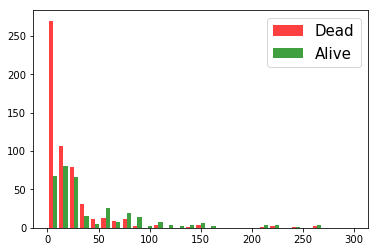

In [16]:
dead = data.loc[data['Survived']==0,'Fare']
alive = data.loc[data['Survived']==1,'Fare']
binBoundaries = np.linspace(0,300,30)
plt.hist([dead,alive], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
plt.legend(['Dead','Alive'],loc=0,prop={'size': 15})

There is a correlation between *Fare* and survival chances, but we would like to make it clearer. Let's use the *Location* variable for this:

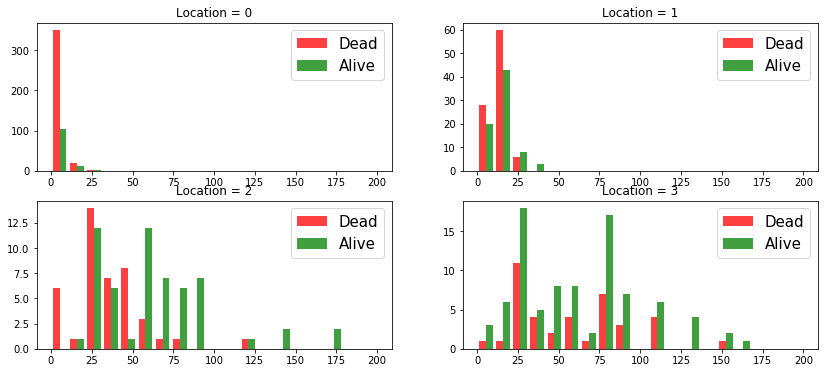

In [17]:
f, axarr = plt.subplots(2, 2,figsize=(14, 6))
binBoundaries = np.linspace(0,200,20)

x0 = dataset.loc[(dataset['Survived']==0) & (dataset['Location']==0),'Fare']
y0 = dataset.loc[(dataset['Survived']==1) & (dataset['Location']==0),'Fare']
axarr[0,0].hist([x0,y0], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0,0].set_title('Location = 0')
axarr[0,0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x1 = dataset.loc[(dataset['Survived']==0) & (dataset['Location']==1),'Fare']
y1 = dataset.loc[(dataset['Survived']==1) & (dataset['Location']==1),'Fare']
axarr[0,1].hist([x1,y1], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0,1].set_title('Location = 1')
axarr[0,1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x2 = dataset.loc[(dataset['Survived']==0) & (dataset['Location']==2),'Fare']
y2 = dataset.loc[(dataset['Survived']==1) & (dataset['Location']==2),'Fare']
axarr[1,0].hist([x2,y2], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1,0].set_title('Location = 2')
axarr[1,0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x3 = dataset.loc[(dataset['Survived']==0) & (dataset['Location']==3),'Fare']
y3 = dataset.loc[(dataset['Survived']==1) & (dataset['Location']==3),'Fare']
axarr[1,1].hist([x3,y3], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1,1].set_title('Location = 3')
axarr[1,1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

The *Location* feature makes a good job, we can simply divide the fare range into 2 additionnal categories to further refine the selectivity. Typically, 50 is a good separation. It allows a very good separation for the *Location* 3 and a decent one for 4 (but it's not really needed honestly). The location 2 has not enough stat, and is is mostly positive (*survived*=1) anyway so it won't change anything. For *Location*=0 or 1, we would rather have a cutoff at 25.

The best compromise (number of category wise) is splitting the *Fare* range into 3 categories: 0 to 25, 25 to 50, and above 50.

### Embarked

We do the same work for the 'Embarked' feature now. There are only 2 data entries which have a NaN here, so instead of creating a new dummy class, we will put them to the most populated one:

In [18]:
dataset['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [19]:
# Embarkment port: merge the 2 lowest populated categories
dataset['Embarked'].fillna('S', inplace=True) # the most frequent class (concerns only 2 entries)
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

Let's plot the **'Embarked' - 'Survived'** dependency now:

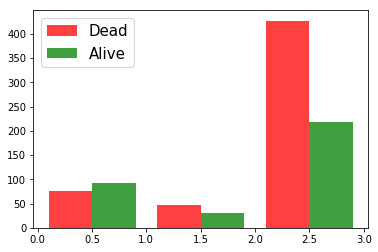

In [20]:
dead = dataset.loc[dataset['Survived']==0,'Embarked']
alive = dataset.loc[dataset['Survived']==1,'Embarked']
binBoundaries = np.linspace(0,3,4)
fig = plt.hist([dead,alive], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
plt.legend(['Dead','Alive'],loc=0,prop={'size': 15})

There is a surprisingly big correlation here, people embarking at Southampton having much bigger chances to die. Since most of the passengers embarked from Southampton, we better have to plot something normalized by the number of passengers from a given port if we want to compare data from one port versus another.

Let's see if the information form *Embarked* is not simply a combination of other informations. Let's start with the *Fare*:

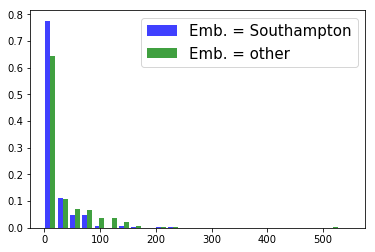

In [21]:
set1 = dataset.loc[dataset['Embarked']==2,'Fare']
set2 = dataset.loc[dataset['Embarked']!=2,'Fare']
weights1 = np.ones_like(set1)/float(len(dataset.loc[dataset['Embarked']==2,'Fare']))
weights2 = np.ones_like(set2)/float(len(dataset.loc[dataset['Embarked']!=2,'Fare']))
binBoundaries = np.linspace(0,550,26)
fig = plt.hist([set1,set2], bins=binBoundaries, weights=[weights1,weights2], log=False, color=['b','g'], alpha=0.75);
plt.legend(['Emb. = Southampton','Emb. = other'],loc=0,prop={'size': 15})

People embarking from Southampton were indeed poorer than others. It contributes to their lower survival chances, as we saw above.

What about gender now? We need to first it to a numerical value to use it:

In [22]:
dataset['Sex'] = le.fit_transform(data['Sex'])
list(le.inverse_transform([0,1]))

['female', 'male']

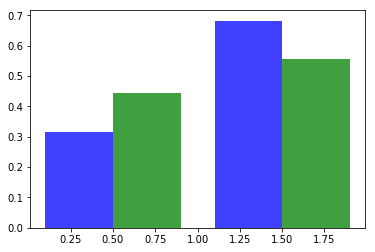

In [23]:
set1 = dataset.loc[dataset['Embarked']==2, 'Sex']
set2 = dataset.loc[dataset['Embarked']!=2, 'Sex']
weights1 = np.ones_like(set1)/float(len(dataset.loc[dataset['Embarked']==2, 'Sex']))
weights2 = np.ones_like(set2)/float(len(dataset.loc[dataset['Embarked']!=2, 'Sex']))
binBoundaries = np.linspace(0,2,3)
fig = plt.hist([set1,set2], bins=binBoundaries, weights=[weights1,weights2], log=False, color=['b','g'], alpha=0.75);

Given the naval traditions (womens and childs first) at this time of history, one could expect a lower survival chance from Southampton passengers on average as their fraction of male passengers is higher than the passengers from other ports.

We can also check the ratio of passenger's embarkment port with age:

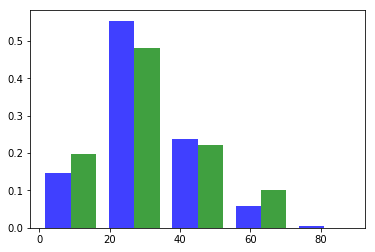

In [24]:
set1 = dataset.loc[ (dataset['Embarked']==2) & (dataset['Age']), 'Age']
set2 = dataset.loc[ (dataset['Embarked']!=2) & (dataset['Age']), 'Age']
weights1 = np.ones_like(set1)/float(len(data.loc[ (dataset['Embarked']==2) & (dataset['Age']<100), 'Age']))
weights2 = np.ones_like(set2)/float(len(data.loc[ (dataset['Embarked']!=2) & (dataset['Age']<100), 'Age']))
binBoundaries = np.linspace(0,90,6)
fig = plt.hist([set1,set2], bins=binBoundaries, weights=[weights1,weights2], log=False, color=['b','g'], alpha=0.75);

As we will see later, *Age* greatly influences survival chances, and the passengers from Southampton have a child/adult ratio lower than passengers from other ports. This is a 3rd contribution to this difference between survival chances from passenger from Southhampton to the others.

We thus can explain most (if not all) of the difference of survival chances from embarkement port from other features. We will thus discard this variable in order to reduce the total number of features.

### Sex

We converted this feature into numerical categories earlier. We now can look at a **'Sex' - 'Survived'** plot

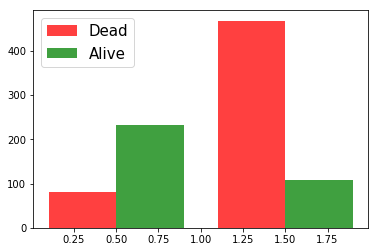

In [25]:
dead = dataset.loc[dataset['Survived']==0,'Sex']
alive = dataset.loc[dataset['Survived']==1,'Sex']
binBoundaries = np.linspace(0,2,3)
fig = plt.hist([dead,alive], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
plt.legend(['Dead','Alive'],loc=0,prop={'size': 15})

Clearly, being a male or a female is a strong factor in determining survival. This feature is already very simple (2 categories) and extremely expressive. We will keep it as it is.

### Age (and Name)

#### First look at age

There is a lot of work for this one:

In [26]:
dataset['Age'].isnull().sum()

177

We miss *Age* values for over 20% of our passengers, and it is an important factor for survival chances as we will see soon. Most of our work here will be to reconstruct *Age* from other features. Let's first plot something to see it's importance.

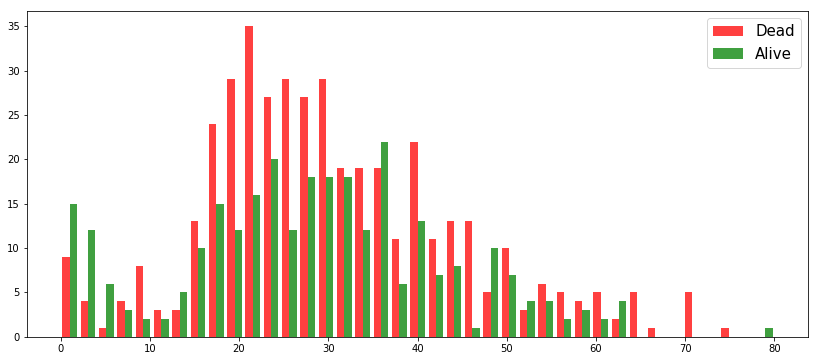

In [27]:
f, axarr = plt.subplots(1, 1,figsize=(14, 6))
binBoundaries = np.linspace(0,80,40)

x0 = dataset.loc[(dataset['Survived']==0) & (dataset['Age']),'Age']
y0 = dataset.loc[(dataset['Survived']==1) & (dataset['Age']),'Age']
axarr.hist([x0,y0], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr.legend(['Dead','Alive'],loc=0,prop={'size': 15})

This plot is quite straightforward. Being a child increase survival chances whereas people from intermediate ages have the lowest chances of survival. Older peoples have better chances than intermediate ages peoples, but is not strong enough to deserve a special treatment. What we will do here, is simply reduce the *Age* feature to a binary-class feature: is the passenger a child or not? I set the separation at 15 years, which yields the best results for me.

But before doing so, we need to fill our NaN in *Age*.

#### Name

As you will probably find on the web, one can extract the title ('Mr.', 'Miss.' etc...) of a passenger from his name field. I first didn't used it but figured out at some point that the title can be quite correlated to the age of a passenger.

Let's first extract the title of passengers:

In [28]:
# Title: extract it from the 'Name', there are correlations with age that can be used
dataset['Name'] = dataset['Name'].str.split(',').str.get(1).str.split().str.get(0) # title comes right after comma
titles = dataset['Name'].value_counts().to_dict() # dict of {titles: counts}
titles

{'Capt.': 1,
 'Col.': 2,
 'Don.': 1,
 'Dr.': 7,
 'Jonkheer.': 1,
 'Lady.': 1,
 'Major.': 2,
 'Master.': 40,
 'Miss.': 182,
 'Mlle.': 2,
 'Mme.': 1,
 'Mr.': 517,
 'Mrs.': 125,
 'Ms.': 1,
 'Rev.': 6,
 'Sir.': 1,
 'the': 1}

There are too many of them, and too few data in most of them. We will then create a 'garbage' category tu put them all, and treat it as a whole. Since fancy titles are not for kids, we will set the NaN *Age* of any of the member of this garbage category to 'Adult':

In [29]:
limits = {}
limits['child'] = 15
limits['titlelimit'] = 10

garbage =  dict((k, v) for k, v in titles.items() if v <= limits['titlelimit']) # titles to be garbaged 
# Fancy titles are not for kids, but for elder peoples:
for title in garbage.keys():
    dataset.loc[(dataset['Name']==title) & (dataset['Age'].isnull()), 'Age'] = limits['child']+1

We can now work around the 4 most represented categories: 'Mr.', 'Miss.', 'Mrs.' and 'Master.'.

Let's start with 'Master.'. In old times, it was used for male child of good families. Let's check this:

In [30]:
[dataset.loc[(dataset['Name']=='Master.') & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Master.') & (dataset['Age']), 'Age'].median()]

[4.574166666666667, 3.5]

That's pretty clear, there are mostly childs there. All the NaN with 'Master.' as title will be then set to the mean value of this category:

In [31]:
# Correlation with 'Master.' title is clear
dataset.loc[(dataset['Name']=='Master.') & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[dataset['Name']=='Master.', 'Age'].mean()

Regarding 'Mrs.', it refers to a married woman. So in principle, such a woman should not be a child:

In [32]:
[dataset.loc[(dataset['Name']=='Mrs.') & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Mrs.') & (dataset['Age']), 'Age'].median()]

[35.898148148148145, 35.0]

Indeed, they are mostly not childrens anymore. Let's set their NaN to the mean value:

In [33]:
# Married ladies aren't child anymore (I hope so at least)
dataset.loc[(dataset['Name']=='Mrs.') & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[(dataset['Name']=='Mrs.') & (dataset['Age']>0), 'Age'].mean()

For 'Mr.' and 'Miss.', which are more general titles, we will use an additional criterion. We will assume that kids doesn't travel alone. So a passenger with *Parch*=0 (number of parents or childs) cannot be a child:

In [34]:
[[dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']==0) & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']==0) & (dataset['Age']), 'Age'].median()],
 [dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']==0) & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']==0) & (dataset['Age']), 'Age'].median()]]

[[32.20428571428572, 29.0], [27.763736263736263, 26.0]]

It's okay, we can set both of 'Mr.' and 'Miss.' with *Parch*=0 to the mean age if they don't already have one:

In [35]:
dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']==0) & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']==0) & (dataset['Age']>0), 'Age'].mean()
dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']==0) & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']==0) & (dataset['Age']>0), 'Age'].mean()

Now for the case *Parch*>0, 2 scenarios are possible for each title: either the passenger is a child travelling with a parent, either the contrary. Let's check what does the statistic tells:

In [36]:
[[dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']>0) & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']>0) & (dataset['Age']), 'Age'].median()],
 [dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']>0) & (dataset['Age']), 'Age'].mean(),
dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']>0) & (dataset['Age']), 'Age'].median()]]

[[33.5625, 35.0], [11.863636363636363, 9.0]]

It seems that back in time, one could not be a young girl and not married! ^^

As for the mens, I do not have yet any interpretation! So let's apply those changes which are still better than replacing NaN with random numbers (I tried):

In [37]:
dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']>0) & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[(dataset['Name']=='Miss.') & (dataset['Parch']>0) & (dataset['Age']>0), 'Age'].mean()
dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']>0) & (dataset['Age'].isnull()), 'Age'] \
          = dataset.loc[(dataset['Name']=='Mr.') & (dataset['Parch']>0) & (dataset['Age']>0), 'Age'].mean()  

We don't have any NaN left in our *Age* feature, so we can now slice *Age* into 2 categories as stated before:

In [38]:
# slice age in 2 categories
dataset.loc[dataset['Age']<limits['child'], 'Age'] = 0
dataset.loc[dataset['Age']>=limits['child'], 'Age'] = 1

### Sibsp and Parch

Both of those features are already nicely encoded:

In [39]:
[dataset['SibSp'].unique(), data['Parch'].unique()]

[array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6])]

Let's check now the influence of passenger's number of sisters/brothers (*SibSp*) and parents/child (*Parch*) on survival chances:

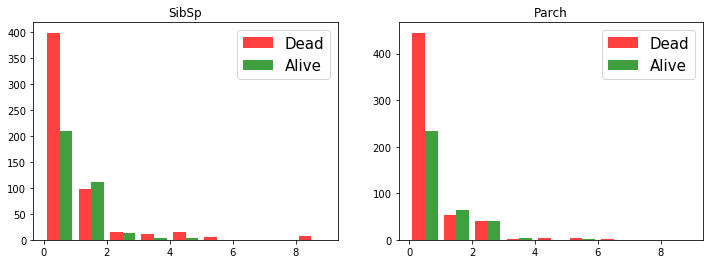

In [40]:
f, axarr = plt.subplots(1, 2,figsize=(12, 4))
binBoundaries = np.linspace(0,9,10)

x0 = dataset.loc[dataset['Survived']==0,'SibSp']
y0 = dataset.loc[dataset['Survived']==1,'SibSp']
axarr[0].hist([x0,y0], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0].set_title('SibSp')
axarr[0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x1 = dataset.loc[dataset['Survived']==0,'Parch']
y1 = dataset.loc[dataset['Survived']==1,'Parch']
axarr[1].hist([x1,y1], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1].set_title('Parch')
axarr[1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

Those 2 features seems to behave in a quite similar way at first glance. We will dig this a bit deeper but we already can see that we will have to compress both, as most of the possibilities doesn't have a relevant statistic. One typically should keep 0, 1 and everything above 1 in a third category for *SibSp*. We might also keep 2 as the ratio dead/survived is below the average. For *Parch*, we should keep 0, 1, 2 and create another category for everything above.

Let's check their mutual dependence before drawing any conclusion. We will plot the *SibSp* dead/survived distribution for 4 slices of *Parch*, the last slice being the concatenation of *Parch*>=3:

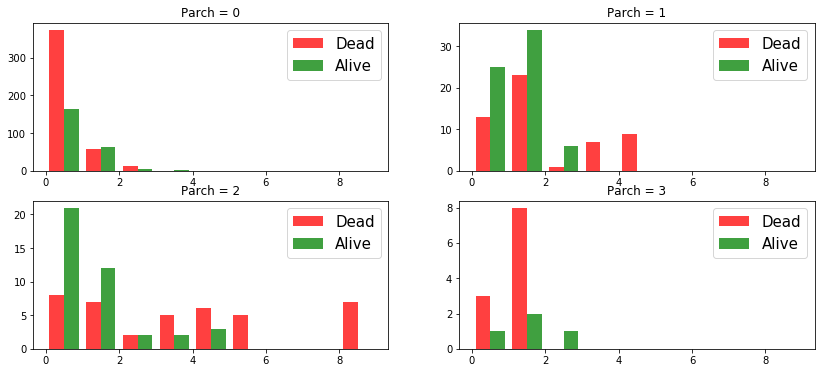

In [41]:
f, axarr = plt.subplots(2, 2,figsize=(14, 6))
binBoundaries = np.linspace(0,9,10)

x0 = dataset.loc[(dataset['Survived']==0) & (dataset['Parch']==0),'SibSp']
y0 = dataset.loc[(dataset['Survived']==1) & (dataset['Parch']==0),'SibSp']
axarr[0,0].hist([x0,y0], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0,0].set_title('Parch = 0')
axarr[0,0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x1 = dataset.loc[(dataset['Survived']==0) & (dataset['Parch']==1),'SibSp']
y1 = dataset.loc[(dataset['Survived']==1) & (dataset['Parch']==1),'SibSp']
axarr[0,1].hist([x1,y1], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[0,1].set_title('Parch = 1')
axarr[0,1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x2 = dataset.loc[(dataset['Survived']==0) & (dataset['Parch']==2),'SibSp']
y2 = dataset.loc[(dataset['Survived']==1) & (dataset['Parch']==2),'SibSp']
axarr[1,0].hist([x2,y2], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1,0].set_title('Parch = 2')
axarr[1,0].legend(['Dead','Alive'],loc=0,prop={'size': 15})

x3 = dataset.loc[(dataset['Survived']==0) & (dataset['Parch']>=3),'SibSp']
y3 = dataset.loc[(dataset['Survived']==1) & (dataset['Parch']>=3),'SibSp']
axarr[1,1].hist([x3,y3], bins=binBoundaries, log=False, color=['r','g'], alpha=0.75);
axarr[1,1].set_title('Parch = 3')
axarr[1,1].legend(['Dead','Alive'],loc=0,prop={'size': 15})

Simply adding *SibSp* to *Parch* will not work much better than keeping those 2 features as they are. But we might build a new feature built on particular combinations of those 2, which we will call *Relatives*. We can see from the figure above several regions with different behavior (number of data entries for a given combination has also been taken into account to decide wether one should consider it as a region or not):

- *Parch*=0 and *SibSp*=0
- *Parch*=0 and *SibSp*=1
- *Parch*=0 and *SibSp*>=2
- *Parch*=1 and *SibSp*<=2
- *Parch*=1 and *SibSp*>=3
- *Parch*=2 and *SibSp*<=1
- *Parch*=2 and *SibSp*>=2
- *Parch*>=3

From there we have 2 possibilities. Either we create a separate category for each, either we group those regions by similar behaviour. The last has the merit to span less categories, which mean our model will be less prone to overfitting, at the possible cost of a better modeling. We will choose this one has I encounters much more overfitting problems than underfittings problems for this dataset. We build our *Relatives* categories as follows:

- *Relatives* = 0 : (*Parch*=0 , *SibSp*=0) + (*Parch*=0 , *SibSp*>=2) + (*Parch*=1 , *SibSp*>=3) + (*Parch*=2 , *SibSp*>=2) + (*Parch*>=3)
- *Relatives* = 1 : (*Parch*=0 , *SibSp*=1) + (*Parch*=1 , *SibSp*<=2) + (*Parch*=2 , *SibSp*<=1)

We can of course refine this feature by changing or adding new combinations. Since we added a *Relatives* column to our dataframe initialzed with 0, we just need to fill the 1 accordingly to the previous rules:

In [42]:
# Adds a Relatives column
dataset = dataset.assign(Relatives=pd.Series(np.zeros(len(dataset),dtype=int)).values)

# Relatives:  fill it depending on SibSp and Parch combination:
dataset.loc[(dataset['Parch']==0) & (dataset['SibSp']==1), 'Relatives'] = 1
dataset.loc[(dataset['Parch']==1) & (dataset['SibSp']<=2), 'Relatives'] = 1
dataset.loc[(dataset['Parch']==2) & (dataset['SibSp']<=1), 'Relatives'] = 1

## Results

There are a lots of models that can be used. I personnally tested under Scikit-Learn a Support Vector Machine, a k-Nearest Neighbour, a Logistic Regression, and a Decision Tree. I set their parameters when needed using a grid search fed by data from a stratified 10-times repeated 5-fold. I also tried an ensemble method and averaged the results from differents models after their training.

Overall, I had the best results using the simpliest models, that's to say the separate models afored-mentioned. I could consistently hit 78.9% accuracy on the test set provided for all those models. It sometimes required some adjustments to the features (particularly for the Logistic Regression). I finally stayed on the first model I tried, the Support Vector Classifier, which produced the most consistent results across all the features changes. Let's be honest, it is not a great result, many people could hit higher scores. It could mean either I didn't use the right models (unlikely since most of the best scores are fom Decision Trees in this competition), either there is more feature engineering to do.

At this stage, we have 5 features (3 of them being binary) split across 10 categories in total. The total number of states for a given input is precisely 96, that's to say about one order of magnitude below the number of data we have. We thus can reasonably hope that each of our combinations is populated by our training set, but with a fairly low statistic, still.

The full code can be found on my github page. The purpose of this challenge was for me to do my first Machine Learning work, and my first Python script, that's why I stopped here to move on something else. I hope this will help newcomers to get into the data analysis. I also hope they will be able to push higher scores!